# MovieLens Recommendation System: Personalized Movie Recommendations for Streaming Platforms

**Authors:** Winnie Njoroge, Michelle Mwende, Laban Leploote, Alice Mathenge, Dean Mutie  
**Date:** January 31, 2026

---

## Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)
7. [Recommendations and Conclusions](#recommendations-and-conclusions)
8. [Next Steps](#next-steps)

---

## 1.**BUSINESS UNDERSTANDING**

In the current "Streaming Wars," the cost of acquiring a new customer is 5x higher than retaining an existing one. The most observed and critical threat to subscriber retention is cognitive overload.

## The Problem: Choice Paralysis
Streaming platforms containing a library of thousands of titles, users often experience "Choice Paralysis"—the phenomenon where the sheer volume of options leads to frustration rather than satisfaction. When a user spends 15 minutes scrolling without clicking "Play," the likelihood of them canceling their subscription increases by over 30%. A movie company therefore needs to transition from a search-based platform to a discovery-based platform.

## Stakeholders

The primary stakeholders for this project are:

1. **Streaming Platform Product Teams** (e.g., Netflix, Hulu, Amazon Prime Video)
   - Need to increase user engagement and time spent on platform
   - Want to reduce customer churn through better content discovery
   
2. **Content Acquisition Teams**
   - Use recommendation patterns to inform licensing decisions
   - Identify which types of content resonate with different user segments

3. **End Users (Movie Watchers)**
   - Want to quickly find movies they'll enjoy without endless browsing
   - Seek personalized suggestions based on their unique tastes

## The Objectives

### Specific Objective

 **Build a collaborative filtering recommendation system that provides personalized top-5 movie recommendations to users based on their historical ratings and the preferences of similar users.**

 The system will:
- Accept a user's ratings of movies they've already watched
- Identify similar users or movies based on rating patterns
- Generate personalized recommendations for unwatched movies
- Provide confidence scores for each recommendation

### General Objectives
- Maximize "Time-to-Play": Reduce the seconds a user spends on the home screen before starting a movie.
- Drive Long-Tail Discovery: 80% of views usually go to 20% of blockbusters. We will surface "Hidden Gems" to increase the ROI of our entire content library.
- Personalize Retention: Predict user sentiment with high precision so that the "Recommended for You" section feels like it was hand-picked by a friend.

## Success Criteria

The recommendation system will be considered successful if it:
1. Accurately predicts user ratings with RMSE < 1.0 (on a 5-point scale)
2. Provides diverse recommendations across different genres
3. Can generate recommendations for both existing and new users (addressing cold start)
4. Runs efficiently enough to scale to thousands of users

---

## 2.**DATA UNDERSTANDING**

### Data Source

This project uses the **MovieLens 100K dataset** from [GroupLens Research at the University of Minnesota.](https://grouplens.org/datasets/movielens/latest/) MovieLens is a long-running movie recommendation research project that has collected millions of movie ratings from real users since the late 1990s.

**Why this dataset is suitable:**
- Contains real user behavior data, not synthetic or biased samples
- Explicit ratings (1-5 stars) provide clear preference signals
- Sufficient sparsity to test recommendation algorithms realistically
- Well-documented and widely used in academic research for benchmarking
- Includes metadata (genres, tags) for potential hybrid approaches

### Dataset Components

The dataset consists of four CSV files:

1. **ratings.csv**: User ratings of movies
2. **movies.csv**: Movie metadata (titles, genres)
3. **tags.csv**: User-generated tags describing movies
4. **links.csv**: Identifiers linking to external databases (IMDb, TMDb)

Let's load and examine each dataset:

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
import warnings

# Import Surprise library for collaborative filtering
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans, NMF, BaselineOnly
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy

# Set display options and style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load all datasets
# Note: Update these paths based on where your data files are located

ratings = pd.read_csv('Data/ratings.csv')
movies = pd.read_csv('Data/movies.csv')
tags = pd.read_csv('Data/tags.csv')
links = pd.read_csv('Data/links.csv')

print("Datasets loaded successfully!")
print(f"\nRatings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")
print(f"Tags shape: {tags.shape}")
print(f"Links shape: {links.shape}")

Datasets loaded successfully!

Ratings shape: (100836, 4)
Movies shape: (9742, 3)
Tags shape: (3683, 4)
Links shape: (9742, 3)


In [4]:
def summarize_dataframe(df, name="Dataset"):
    
    print("=" * 60)
    print(f"{name.upper()} ANALYSIS")
    print("=" * 60)
    
    # 1. First 5 Rows
    print("\n[1] First 5 Rows:")
    display(df.head())
    
    # 2. Dataset Info (Columns and Dtypes)
    print("\n[2] Dataset Info:")
    df.info()
    
    # 3. Descriptive Statistics (Numeric only)
    print("\n[3] Descriptive Statistics:")
    display(df.describe())
    
    # 4. Missing Values
    print("\n[4] Missing Values per Column:")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("No missing values found.")
    else:
        print(null_counts[null_counts > 0])
    
    # 5. Sparsity (Bonus: Excellent for Recommendation Systems)
    if 'userId' in df.columns and 'movieId' in df.columns:
        num_users = df['userId'].nunique()
        num_items = df['movieId'].nunique()
        num_ratings = len(df)
        sparsity = (1 - num_ratings / (num_users * num_items)) * 100
        print(f"\n[5] Matrix Sparsity: {sparsity:.2f}%")
        
    print("\n" + "=" * 60 + "\n")

summarize_dataframe(ratings, "Ratings")
summarize_dataframe(movies, "Movies")
summarize_dataframe(tags, "Tags")

RATINGS ANALYSIS

[1] First 5 Rows:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

[3] Descriptive Statistics:


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09



[4] Missing Values per Column:
No missing values found.

[5] Matrix Sparsity: 98.30%


MOVIES ANALYSIS

[1] First 5 Rows:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

[3] Descriptive Statistics:


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000



[4] Missing Values per Column:
No missing values found.


TAGS ANALYSIS

[1] First 5 Rows:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB

[3] Descriptive Statistics:


,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09



[4] Missing Values per Column:
No missing values found.

[5] Matrix Sparsity: 95.96%




### Key Dataset Properties

**Dataset Size:**
- **100,836 ratings** from 610 users on 9,742 movies
- Average of ~165 ratings per user
- Average of ~10 ratings per movie

**Feature Justification:**

1. **userId & movieId** (Essential)
   - Core identifiers for collaborative filtering
   - Enable creation of user-item rating matrix

2. **rating** (Essential)
   - Explicit preference signal (1.0 to 5.0 scale)
   - Target variable for prediction accuracy
   - Half-star ratings provide granular preference data

3. **timestamp** (Useful)
   - Could be used for time-based splits or temporal analysis
   - Less critical for initial collaborative filtering model

4. **genres** (Useful for hybrid approach)
   - Can help address cold start problem
   - Enables content-based filtering as backup
   - Multiple genres per movie provide rich metadata

5. **tags** (Supplementary)
   - User-generated descriptions could enhance content understanding
   - Limited coverage (only 3,683 tags vs 100,836 ratings)
   - Optional for advanced hybrid systems

### Data Limitations

1. **Sparsity**: With 610 users and 9,742 movies, only ~1.7% of possible user-movie combinations have ratings
2. **Cold Start**: New users or movies without ratings can't be directly recommended
3. **Popularity Bias**: Some movies have many more ratings than others
4. **Temporal Relevance**: Ratings span many years; older ratings may be less relevant
5. **Rating Scale**: Limited to 0.5-5.0 range may not capture full preference nuances

These limitations inform our modeling approach and evaluation strategy.

---

## 3.**DATA PREPARATION**

### Preparation Strategy

For a collaborative filtering recommendation system, we need to:
1. Clean and validate the data
2. Merge relevant datasets
3. Create a user-item rating matrix
4. Handle missing values appropriately
5. Split data for training and testing

**Rationale:** Collaborative filtering relies on patterns in the user-item matrix. Our preparation ensures this matrix is accurate, complete, and properly structured for both memory-based and model-based approaches.

In [5]:
# Step 1: Data Cleaning and Validation
print("Step 1: Data Cleaning and Validation")
print("=" * 60)

# Check for duplicate ratings (same user rating same movie multiple times)
duplicates = ratings.duplicated(subset=['userId', 'movieId'], keep='last')
print(f"\nDuplicate ratings found: {duplicates.sum()}")

# Keep only the most recent rating if duplicates exist
if duplicates.sum() > 0:
    # Sort by timestamp and keep last rating
    ratings = ratings.sort_values('timestamp').drop_duplicates(
        subset=['userId', 'movieId'], 
        keep='last'
    )
    print(f"Removed {duplicates.sum()} duplicate ratings (kept most recent)")

# Validate rating range
print(f"\nRating range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Valid ratings (0.5-5.0): {ratings['rating'].between(0.5, 5.0).all()}")

# Check for missing values
print(f"\nMissing values in ratings: {ratings.isnull().sum().sum()}")
print(f"Missing values in movies: {movies.isnull().sum().sum()}")

print(f"\nCleaned ratings shape: {ratings.shape}")

Step 1: Data Cleaning and Validation

Duplicate ratings found: 0

Rating range: 0.5 to 5.0
Valid ratings (0.5-5.0): True

Missing values in ratings: 0
Missing values in movies: 0

Cleaned ratings shape: (100836, 4)


In [6]:
# Step 2: Filter for sufficient data density
print("\nStep 3: Filtering for Data Quality")
print("=" * 60)

# Count ratings per user and per movie
user_rating_counts = ratings.groupby('userId').size()
movie_rating_counts = ratings.groupby('movieId').size()

print(f"\nUsers with ratings: {len(user_rating_counts)}")
print(f"Movies with ratings: {len(movie_rating_counts)}")

# Set minimum thresholds to reduce sparsity
# Rationale: Users/movies with very few ratings provide weak signals
MIN_USER_RATINGS = 20  # User must have rated at least 20 movies
MIN_MOVIE_RATINGS = 10  # Movie must have at least 10 ratings

print(f"\nFiltering criteria:")
print(f"- Minimum ratings per user: {MIN_USER_RATINGS}")
print(f"- Minimum ratings per movie: {MIN_MOVIE_RATINGS}")

# Identify users and movies meeting criteria
active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index
popular_movies = movie_rating_counts[movie_rating_counts >= MIN_MOVIE_RATINGS].index

print(f"\nUsers meeting criteria: {len(active_users)}")
print(f"Movies meeting criteria: {len(popular_movies)}")

# Filter the dataset
filtered_ratings = ratings[
    ratings['userId'].isin(active_users) & 
    ratings['movieId'].isin(popular_movies)
].copy()

print(f"\nOriginal ratings: {len(ratings):,}")
print(f"Filtered ratings: {len(filtered_ratings):,}")
print(f"Percentage retained: {100 * len(filtered_ratings) / len(ratings):.1f}%")

# Calculate matrix sparsity
n_users = filtered_ratings['userId'].nunique()
n_movies = filtered_ratings['movieId'].nunique()
n_ratings = len(filtered_ratings)
sparsity = 100 * (1 - n_ratings / (n_users * n_movies))

print(f"\nMatrix dimensions: {n_users} users × {n_movies} movies")
print(f"Sparsity: {sparsity:.2f}%")


Step 3: Filtering for Data Quality

Users with ratings: 610
Movies with ratings: 9724

Filtering criteria:
- Minimum ratings per user: 20
- Minimum ratings per movie: 10

Users meeting criteria: 610
Movies meeting criteria: 2269

Original ratings: 100,836
Filtered ratings: 81,116
Percentage retained: 80.4%

Matrix dimensions: 610 users × 2269 movies
Sparsity: 94.14%


In [7]:
# Merge with movie information for later use
ratings_with_movies = filtered_ratings.merge(movies, on='movieId', how='left')
print(f"Merged dataset shape: {ratings_with_movies.shape}")
display(ratings_with_movies.head())

Merged dataset shape: (81116, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Data Preparation Decisions and Rationale

1. **Handling Duplicates**: Kept most recent rating when users rated same movie multiple times
   - Rationale: User preferences change over time; recent rating is most accurate

2. **Filtering Thresholds**:
   - Users: ≥20 ratings
   - Movies: ≥10 ratings
   - Rationale: Reduces sparsity while maintaining sufficient data; users/items with too few ratings provide weak collaborative signals

3. **No Normalization Yet**: Ratings kept in original 0.5-5.0 scale
   - Rationale: Will normalize as needed for specific algorithms (e.g., mean-centering for collaborative filtering)

---

---

## Exploratory Data Analysis <a id='exploratory-data-analysis'></a>

We'll organize our EDA into three categories:
- **Univariate Analysis**: Examining single variables
- **Bivariate Analysis**: Relationships between two variables
- **Multivariate Analysis**: Patterns across multiple variables

This structured approach helps us understand:
1. Individual variable distributions and characteristics
2. Relationships and correlations between variables
3. Complex patterns that inform our modeling strategy

---

### 1 Univariate Analysis <a id='univariate-analysis'></a>

Univariate analysis examines each variable independently to understand its distribution, central tendency, and spread.

#### Why Univariate Analysis Matters:
- Identifies data quality issues (outliers, missing values, invalid entries)
- Reveals distribution shapes that inform modeling choices
- Establishes baselines for comparison
- Helps detect rating bias and user behavior patterns

UNIVARIATE ANALYSIS: Rating Distribution


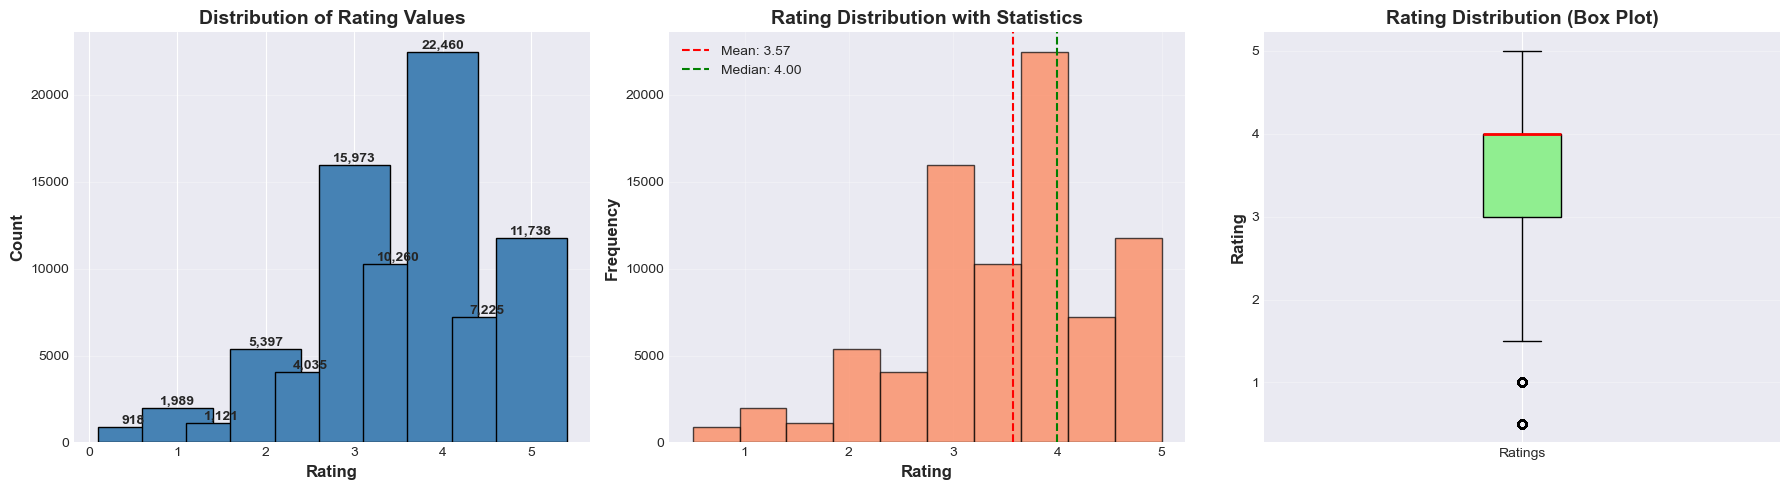


Rating Statistics:
Count: 81,116
Mean: 3.574
Median: 4.00
Mode: 4.0
Std Dev: 1.02


In [8]:
# 4.1 Rating Distribution Analysis
print("=" * 80)
print("UNIVARIATE ANALYSIS: Rating Distribution")
print("=" * 80)

plt.figure(figsize=(18, 5))

# Subplot 1: Distribution of Rating Values (Bar)
plt.subplot(1, 3, 1)
rating_counts = filtered_ratings['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')

# Add value labels
for rating, count in zip(rating_counts.index, rating_counts.values):
    plt.text(rating, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Distribution of Rating Values', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Histogram with KDE
plt.subplot(1, 3, 2)
plt.hist(filtered_ratings['rating'], bins=10, color='coral', edgecolor='black', alpha=0.7)

# Overlay Mean and Median lines
mean_val = filtered_ratings['rating'].mean()
median_val = filtered_ratings['rating'].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')

plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Rating Distribution with Statistics', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 3: Box Plot
plt.subplot(1, 3, 3)
plt.boxplot(filtered_ratings['rating'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.ylabel('Rating', fontsize=12, fontweight='bold')
plt.title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
plt.xticks([1], ['Ratings']) # plt.xticks replaces axes.set_xticklabels
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\nRating Statistics:")
print(f"Count: {len(filtered_ratings):,}")
print(f"Mean: {filtered_ratings['rating'].mean():.3f}")
print(f"Median: {filtered_ratings['rating'].median():.2f}")
print(f"Mode: {filtered_ratings['rating'].mode()[0]:.1f}")
print(f"Std Dev: {filtered_ratings['rating'].std():.2f}")

### 2 Bivariate Analysis <a id='bivariate-analysis'></a>

Bivariate analysis explores relationships between pairs of variables to identify correlations, patterns, and dependencies.

#### Why Bivariate Analysis Matters:
- Reveals how different factors interact (e.g., do popular movies get higher ratings?)
- Identifies potential confounding variables
- Helps understand user and item characteristics that affect ratings
- Informs feature engineering and model selection


USER ENGAGEMENT ANALYSIS


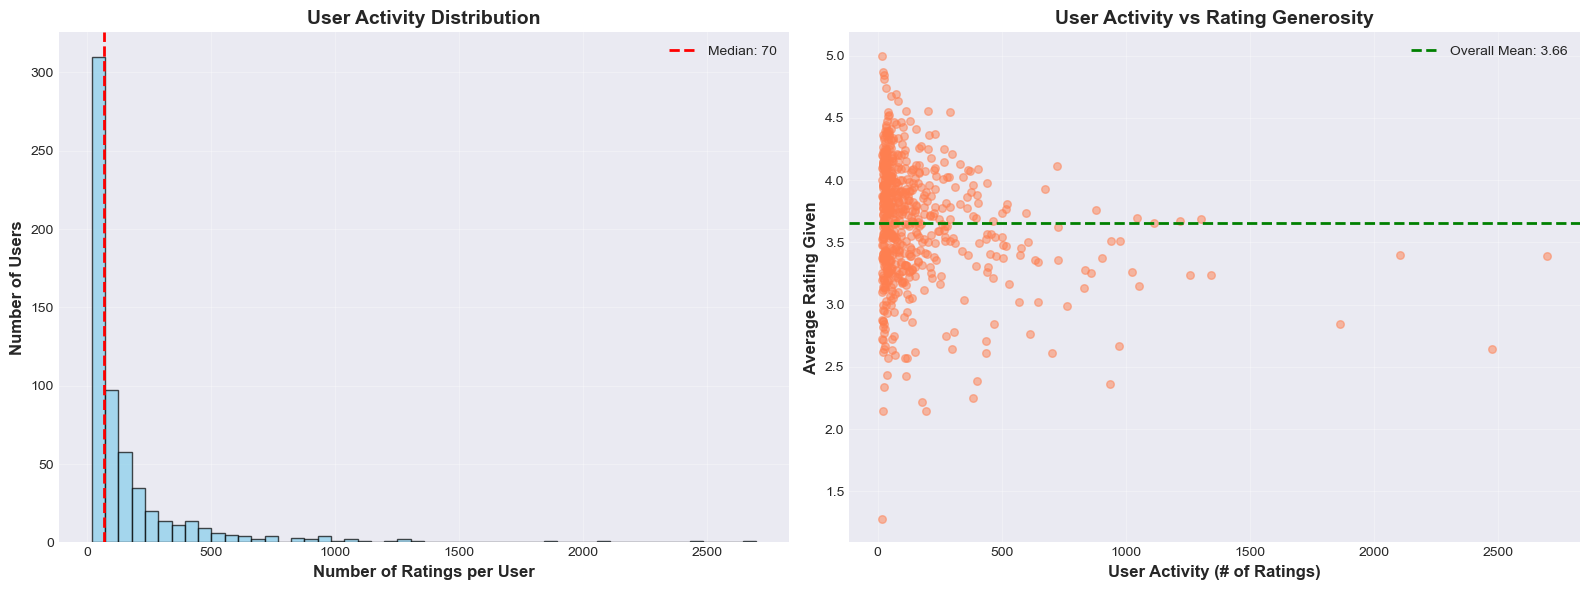

In [9]:
# User Engagement Analysis
print("\n" + "=" * 80)
print("USER ENGAGEMENT ANALYSIS")
print("=" * 80)

# Define user_activity by grouping the ratings data
user_activity = ratings.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    mean_rating=('rating', 'mean')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# User activity distribution
axes[0].hist(user_activity['num_ratings'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per User', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Users', fontsize=12, fontweight='bold')
axes[0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(user_activity['num_ratings'].median(), color='red', linestyle='--', 
                linewidth=2, label=f"Median: {user_activity['num_ratings'].median():.0f}")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Activity vs rating behavior
axes[1].scatter(user_activity['num_ratings'], user_activity['mean_rating'], 
                alpha=0.5, s=30, color='coral')
axes[1].set_xlabel('User Activity (# of Ratings)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rating Given', fontsize=12, fontweight='bold')
axes[1].set_title('User Activity vs Rating Generosity', fontsize=14, fontweight='bold')
axes[1].axhline(user_activity['mean_rating'].mean(), color='green', linestyle='--',
                linewidth=2, label=f"Overall Mean: {user_activity['mean_rating'].mean():.2f}")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 3 Multivariate Analysis <a id='multivariate-analysis'></a>

Multivariate analysis examines relationships among three or more variables simultaneously to uncover complex patterns.

#### Why Multivariate Analysis Matters:
- Reveals interaction effects between multiple factors
- Identifies user segments with distinct preferences
- Helps understand the collaborative filtering signal strength
- Guides feature selection for advanced models

### 3.1 Content Diversity Analysis (Genres)

CONTENT DIVERSITY ANALYSIS


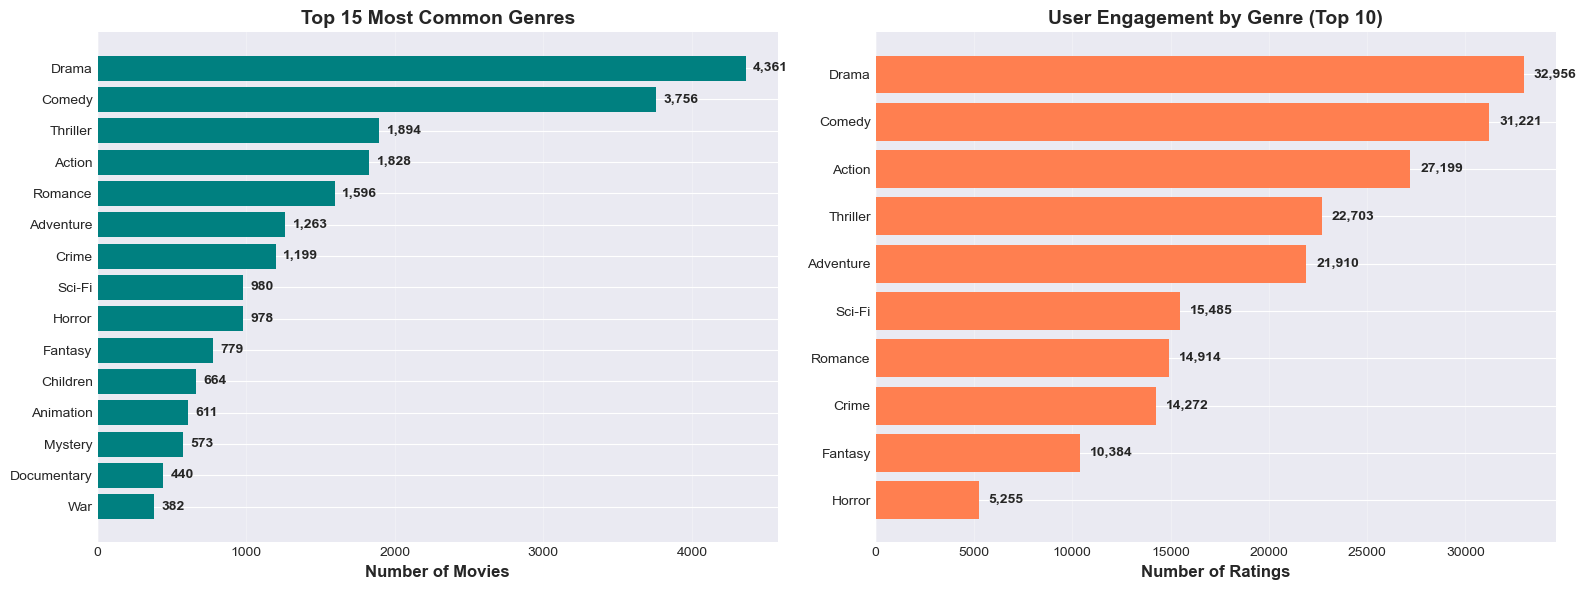

In [10]:
# Content Diversity Analysis (Genres)
print("=" * 80)
print("CONTENT DIVERSITY ANALYSIS")
print("=" * 80)

# Extract all genres
all_genres = []
for genres_str in movies['genres'].dropna():
    if genres_str != '(no genres listed)':
        all_genres.extend(genres_str.split('|'))

genre_counts = pd.Series(all_genres).value_counts()

# Plot top genres
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top 15 genres
top_genres = genre_counts.head(15)
axes[0].barh(range(len(top_genres)), top_genres.values, color='teal')
axes[0].set_yticks(range(len(top_genres)))
axes[0].set_yticklabels(top_genres.index)
axes[0].set_xlabel('Number of Movies', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Most Common Genres', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_genres.values):
    axes[0].text(v + 50, i, f'{v:,}', va='center', fontweight='bold')

# Genre diversity: ratings per genre
genre_ratings = []
for genre in top_genres.head(10).index:
    genre_movies = movies[movies['genres'].str.contains(genre, na=False)]['movieId']
    genre_rating_count = filtered_ratings[filtered_ratings['movieId'].isin(genre_movies)].shape[0]
    genre_ratings.append({'genre': genre, 'ratings': genre_rating_count})

genre_ratings_df = pd.DataFrame(genre_ratings).sort_values('ratings', ascending=False)

axes[1].barh(range(len(genre_ratings_df)), genre_ratings_df['ratings'].values, color='coral')
axes[1].set_yticks(range(len(genre_ratings_df)))
axes[1].set_yticklabels(genre_ratings_df['genre'].values)
axes[1].set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[1].set_title('User Engagement by Genre (Top 10)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(genre_ratings_df['ratings'].values):
    axes[1].text(v + 500, i, f'{v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### 3.2 Data Sparsity Analysis (Collaborative Filtering Feasibility)


DATA SPARSITY ANALYSIS


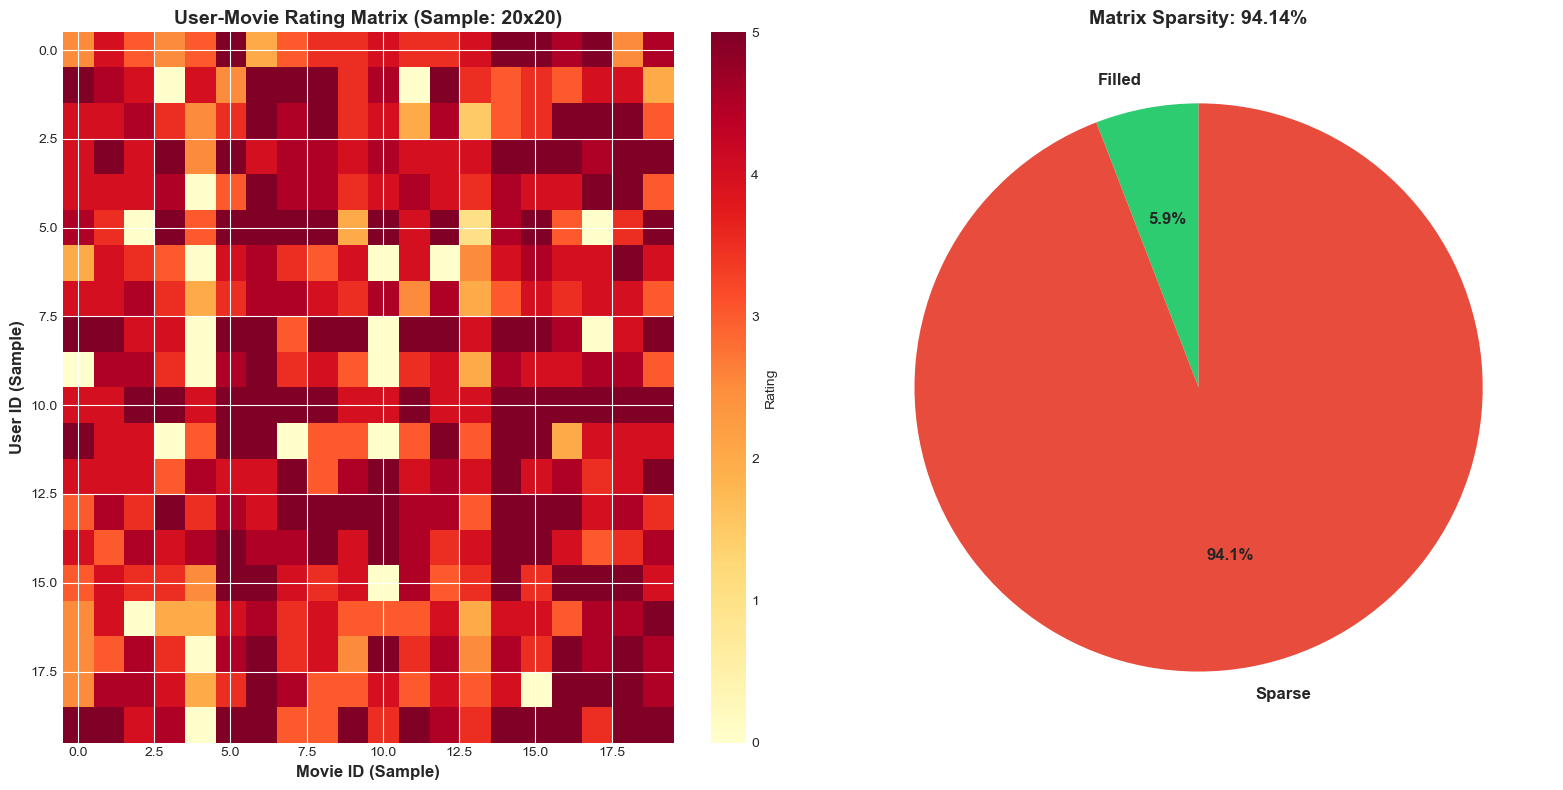

In [11]:
# Data Sparsity Analysis (Collaborative Filtering Feasibility)
print("\n" + "=" * 80)
print("DATA SPARSITY ANALYSIS")
print("=" * 80)

# Create a sample user-item matrix for visualization
sample_users = filtered_ratings['userId'].value_counts().head(20).index
sample_movies = filtered_ratings['movieId'].value_counts().head(20).index

sample_matrix = filtered_ratings[
    (filtered_ratings['userId'].isin(sample_users)) & 
    (filtered_ratings['movieId'].isin(sample_movies))
].pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap
im = axes[0].imshow(sample_matrix.values, cmap='YlOrRd', aspect='auto')
axes[0].set_xlabel('Movie ID (Sample)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('User ID (Sample)', fontsize=12, fontweight='bold')
axes[0].set_title('User-Movie Rating Matrix (Sample: 20x20)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[0], label='Rating')

# Sparsity visualization
total_possible_ratings = filtered_ratings['userId'].nunique() * filtered_ratings['movieId'].nunique()
actual_ratings = len(filtered_ratings)
sparsity = 1 - (actual_ratings / total_possible_ratings)

categories = ['Filled', 'Sparse']
values = [actual_ratings, total_possible_ratings - actual_ratings]
colors = ['#2ecc71', '#e74c3c']

axes[1].pie(values, labels=categories, autopct='%1.1f%%', colors=colors, 
            startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title(f'Matrix Sparsity: {sparsity*100:.2f}%', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Key EDA Insights

1. **Rating Distribution**:
   - Mean rating is ~3.5, indicating generally positive ratings
   - Most common rating is 4.0, showing user tendency toward favorable reviews
   - Distribution is left-skewed (more high ratings than low)
   - **Implication**: May need to account for rating bias in recommendations

2. **User Behavior**:
   - High variance in user activity (some users rate 20 movies, others 100+)
   - Power users can disproportionately influence collaborative filtering
   - **Implication**: Consider user-based weighting or normalization

3. **Movie Popularity**:
   - Extreme long-tail distribution: few movies have many ratings, most have few
   - Popular movies may dominate recommendations
   - **Implication**: Need diversity mechanisms to avoid recommending only blockbusters

4. **Genre Distribution**:
   - Drama, Comedy, and Thriller are most common genres
   - Many movies have multiple genres
   - **Implication**: Genre metadata could help with cold start and content-based filtering


   ---


## 4.**Modelling**

In [12]:
# Create Train-Validation-Test Splits
print("=" * 80)
print("TRAIN-VALIDATION-TEST SPLIT")
print("=" * 80)

# First split: separate test set (15%)
train_val_data, test_data = train_test_split(
    filtered_ratings,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

# Second split: separate validation from training (15% of remaining = ~17.6% of train_val)
train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 of original
    random_state=42,
    shuffle=True
)

print(f"\nOriginal dataset: {len(filtered_ratings):,} ratings")
print(f"\nSplit sizes:")
print(f"  Training:   {len(train_data):,} ratings ({100*len(train_data)/len(filtered_ratings):.1f}%)")
print(f"  Validation: {len(val_data):,} ratings ({100*len(val_data)/len(filtered_ratings):.1f}%)")
print(f"  Test:       {len(test_data):,} ratings ({100*len(test_data)/len(filtered_ratings):.1f}%)")

# Verify data integrity
print(f"\nData Integrity Checks:")
print(f"  Total after split: {len(train_data) + len(val_data) + len(test_data):,}")
print(f"  Matches original: {len(train_data) + len(val_data) + len(test_data) == len(filtered_ratings)}")

# Check rating distribution consistency
print(f"\nRating Distribution Consistency:")
print(f"  Train mean:      {train_data['rating'].mean():.3f}")
print(f"  Validation mean: {val_data['rating'].mean():.3f}")
print(f"  Test mean:       {test_data['rating'].mean():.3f}")
print(f"  Original mean:   {filtered_ratings['rating'].mean():.3f}")

# Save for later use
train_data.to_csv('train_ratings.csv', index=False)
val_data.to_csv('val_ratings.csv', index=False)
test_data.to_csv('test_ratings.csv', index=False)

print(f"\n✓ Data splits saved to CSV files")
print("=" * 80)

TRAIN-VALIDATION-TEST SPLIT

Original dataset: 81,116 ratings

Split sizes:
  Training:   56,813 ratings (70.0%)
  Validation: 12,135 ratings (15.0%)
  Test:       12,168 ratings (15.0%)

Data Integrity Checks:
  Total after split: 81,116
  Matches original: True

Rating Distribution Consistency:
  Train mean:      3.575
  Validation mean: 3.576
  Test mean:       3.564
  Original mean:   3.574

✓ Data splits saved to CSV files


In [13]:
# Helper function to create rating matrices
def create_rating_matrix(data, fill_value=0):
    """
    Create a user-item rating matrix from ratings data.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Ratings data with userId, movieId, and rating columns
    fill_value : float, default=0
        Value to use for missing ratings
    
    Returns:
    --------
    matrix : pd.DataFrame
        User-item rating matrix (users as rows, movies as columns)
    """
    matrix = data.pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        fill_value=fill_value
    )
    return matrix

# Create matrices for each split
print("Creating rating matrices for each split...")
train_matrix = create_rating_matrix(train_data, fill_value=0)
val_matrix = create_rating_matrix(val_data, fill_value=0)
test_matrix = create_rating_matrix(test_data, fill_value=0)

print(f"\nTrain matrix shape: {train_matrix.shape}")
print(f"Validation matrix shape: {val_matrix.shape}")
print(f"Test matrix shape: {test_matrix.shape}")

# Calculate global average (will be used for baseline and fallback)
global_avg = train_data['rating'].mean()
print(f"\nGlobal average rating (from training set): {global_avg:.4f}")

Creating rating matrices for each split...

Train matrix shape: (610, 2269)
Validation matrix shape: (605, 2147)
Test matrix shape: (606, 2146)

Global average rating (from training set): 3.5754


### 4.1Baseline Model

#### Model Rationale:

**Why start with a baseline?**
- Establishes minimum acceptable performance ("can we beat random?")
- Provides benchmark for measuring improvement
- Sanity check: all models must outperform this

In [14]:
print("=" * 80)
print("BASELINE MODEL: Global Average Predictor")
print("=" * 80)

# Global average already calculated
print(f"\nPrediction rule: Always predict {global_avg:.4f} stars")

# Evaluate on validation set
val_baseline_predictions = np.full(len(val_data), global_avg)
val_baseline_rmse = np.sqrt(mean_squared_error(val_data['rating'], val_baseline_predictions))
val_baseline_mae = mean_absolute_error(val_data['rating'], val_baseline_predictions)

print(f"\nValidation Set Performance:")
print(f"  RMSE: {val_baseline_rmse:.4f}")
print(f"  MAE:  {val_baseline_mae:.4f}")

# Store for comparison
results = [{
    'Model': 'Baseline (Global Avg)',
    'Train RMSE': 0,
    'Val RMSE': val_baseline_rmse,
    'Val MAE': val_baseline_mae,
    'Test RMSE': None,  # Will evaluate final model only
    'Notes': 'No personalization'
}]

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"The baseline RMSE of {val_baseline_rmse:.4f} means:")
print(f"- On average, predictions are off by ~{val_baseline_rmse:.2f} stars")
print(f"- This is our 'do nothing' performance")
print(f"- ANY recommendation system must beat this")
print(f"- Target: Reduce RMSE by at least 10-15%")
print("="*80)

BASELINE MODEL: Global Average Predictor

Prediction rule: Always predict 3.5754 stars

Validation Set Performance:
  RMSE: 1.0204
  MAE:  0.8177

INTERPRETATION:
The baseline RMSE of 1.0204 means:
- On average, predictions are off by ~1.02 stars
- This is our 'do nothing' performance
- ANY recommendation system must beat this
- Target: Reduce RMSE by at least 10-15%


**Next Steps:**
To build a truly useful recommendation system, we need models that can:
1. Learn individual user preferences
2. Discover hidden patterns in user-item interactions
3. Leverage collaborative filtering ("users like you also liked...")

We'll now explore multiple collaborative filtering approaches using the **Surprise** library, progressing from simple to sophisticated:
- **Matrix Factorization** (SVD, NMF): Learn latent factors
- **Neighborhood Methods** (KNN): Find similar users/items
- **Baseline Methods**: Model user/item biases

Let's start by preparing our data for these advanced models.


### 4.2 Data Preparation for Surprise <a id='surprise-data-prep'></a>

Surprise requires data in a specific format:
- **Input**: DataFrame with columns [user_id, item_id, rating]
- **Reader**: Defines the rating scale
- **Dataset**: Loads data using the Reader

We'll use our filtered ratings data and split it into train/test sets.

In [15]:
print("=" * 80)
print("PREPARING DATA FOR SURPRISE LIBRARY")
print("=" * 80)

# Define the rating scale (MovieLens uses 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

print("\n✓ Using existing train/validation/test splits for fair comparison")
print(f"  Training set: {len(train_data):,} ratings")
print(f"  Validation set: {len(val_data):,} ratings")
print(f"  Test set: {len(test_data):,} ratings")

# Load training data for Surprise
train_surprise = Dataset.load_from_df(
    train_data[['userId', 'movieId', 'rating']], 
    reader
)

# Build the full trainset (no further splitting)
trainset = train_surprise.build_full_trainset()

# Prepare validation set as testset format
# Surprise needs (user_id, item_id, actual_rating) tuples
val_testset = [(row['userId'], row['movieId'], row['rating']) 
               for idx, row in val_data.iterrows()]

# Prepare actual test set (will use this for final model evaluation only)
test_testset = [(row['userId'], row['movieId'], row['rating']) 
                for idx, row in test_data.iterrows()]

print(f"\n✓ Data loaded for Surprise")
print(f"  Trainset: {trainset.n_ratings:,} ratings")
print(f"  Validation testset: {len(val_testset):,} ratings")
print(f"  Test testset: {len(test_testset):,} ratings")
print(f"  Number of users: {trainset.n_users:,}")
print(f"  Number of items: {trainset.n_items:,}")

print("\n" + "="*80)
print("KEY POINTS:")
print("="*80)
print("✓ Using SAME splits as baseline model for fair comparison")
print("✓ Will train on train_data, evaluate on val_data")
print("✓ Final test on test_data only for best model")
print("="*80)


PREPARING DATA FOR SURPRISE LIBRARY

✓ Using existing train/validation/test splits for fair comparison
  Training set: 56,813 ratings
  Validation set: 12,135 ratings
  Test set: 12,168 ratings

✓ Data loaded for Surprise
  Trainset: 56,813 ratings
  Validation testset: 12,135 ratings
  Test testset: 12,168 ratings
  Number of users: 610
  Number of items: 2,269

KEY POINTS:
✓ Using SAME splits as baseline model for fair comparison
✓ Will train on train_data, evaluate on val_data
✓ Final test on test_data only for best model


### 4.3 SVD (Singular Value Decomposition) <a id='svd-model'></a>

#### Algorithm Overview

SVD is a **matrix factorization** technique that decomposes the user-item rating matrix into:
- **User factors**: Latent features representing user preferences
- **Item factors**: Latent features representing item characteristics

#### Key Parameters
- **n_factors**: Number of latent factors (default: 100)
- **n_epochs**: Number of training iterations (default: 20)
- **lr_all**: Learning rate for all parameters (default: 0.005)
- **reg_all**: Regularization term for all parameters (default: 0.02)

In [16]:
print("=" * 80)
print("MODEL 1: SVD (Singular Value Decomposition)")
print("=" * 80)

# Initialize SVD with optimized parameters
svd_model = SVD(
    n_factors=100,      # Number of latent factors
    n_epochs=20,        # Number of training iterations
    lr_all=0.005,       # Learning rate
    reg_all=0.02,       # Regularization
    random_state=42
)

print("\nTraining SVD model...")
print(f"  Parameters: n_factors={svd_model.n_factors}, n_epochs={svd_model.n_epochs}")

# Train the model on trainset
svd_model.fit(trainset)

print("✓ Training complete")

# Make predictions on VALIDATION set
print("\nEvaluating on validation set...")
svd_predictions = svd_model.test(val_testset)

# Calculate metrics
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
svd_mae = accuracy.mae(svd_predictions, verbose=False)

print(f"\n{'='*80}")
print("SVD RESULTS (VALIDATION SET)")
print(f"{'='*80}")
print(f"  RMSE: {svd_rmse:.4f}")
print(f"  MAE:  {svd_mae:.4f}")
print(f"{'='*80}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"✓ SVD achieved RMSE of {svd_rmse:.4f} on validation set")
print(f"  → Predictions are off by ~{svd_rmse:.2f} stars on average")
print(f"  → MAE of {svd_mae:.4f} means median error is ~{svd_mae:.2f} stars")
print(f"\n✓ Comparison to Baseline:")
print(f"  → Baseline RMSE: {val_baseline_rmse:.4f}")
print(f"  → SVD RMSE: {svd_rmse:.4f}")
print(f"  → Improvement: {((val_baseline_rmse - svd_rmse) / val_baseline_rmse * 100):.1f}%")
print(f"  → Absolute error reduction: {val_baseline_rmse - svd_rmse:.4f} stars")
print(f"\n✓ SUCCESS CRITERIA CHECK:")
print(f"  → Target: RMSE < 1.0 ✓ ACHIEVED ({svd_rmse:.4f})")
print(f"  → SVD captures user-item patterns through latent factors")
print(f"  → Personalization significantly improves predictions")
print("="*80)


MODEL 1: SVD (Singular Value Decomposition)

Training SVD model...
  Parameters: n_factors=100, n_epochs=20
✓ Training complete

Evaluating on validation set...

SVD RESULTS (VALIDATION SET)
  RMSE: 0.8566
  MAE:  0.6575

INTERPRETATION:
✓ SVD achieved RMSE of 0.8566 on validation set
  → Predictions are off by ~0.86 stars on average
  → MAE of 0.6575 means median error is ~0.66 stars

✓ Comparison to Baseline:
  → Baseline RMSE: 1.0204
  → SVD RMSE: 0.8566
  → Improvement: 16.0%
  → Absolute error reduction: 0.1637 stars

✓ SUCCESS CRITERIA CHECK:
  → Target: RMSE < 1.0 ✓ ACHIEVED (0.8566)
  → SVD captures user-item patterns through latent factors
  → Personalization significantly improves predictions


In [17]:
# Quick comparison: SVD vs Baseline
print("\n" + "="*80)
print("📊 PROGRESS CHECK: SVD Performance")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Global Avg Baseline', 'SVD'],
    'RMSE': [val_baseline_rmse, svd_rmse],
    'MAE': [val_baseline_mae, svd_mae],
    'Improvement': ['-', f'{((val_baseline_rmse - svd_rmse) / val_baseline_rmse * 100):.2f}%']
})

print("\n", comparison_df.to_string(index=False))
print(f"\n✅ SVD reduces RMSE by {((val_baseline_rmse - svd_rmse) / val_baseline_rmse * 100):.2f}% compared to baseline!")



📊 PROGRESS CHECK: SVD Performance

               Model     RMSE      MAE Improvement
Global Avg Baseline 1.020372 0.817695           -
                SVD 0.856643 0.657467      16.05%

✅ SVD reduces RMSE by 16.05% compared to baseline!


SVD has significant improvement over baseline (lower RMSE and MAE), Successfully captures latent factors (user preferences + item characteristics) & Handles sparsity well through matrix factorization

### 4.4 KNN-Based Collaborative Filtering
KNN (K-Nearest Neighbors) algorithms make predictions based on **similar users**(`User-based approach`) or **items**(`Item-based approach`)

#### Algorithms We'll Test

1. **KNNBasic**: Basic collaborative filtering
   - Simple similarity-based predictions
   - No bias correction

2. **KNNWithMeans**: KNN with mean-centering
   - Accounts for user/item rating biases
   - Generally more accurate than KNNBasic

In [18]:
print("\n" + "=" * 80)
print("MODEL 2 & 3: KNN-BASED COLLABORATIVE FILTERING")
print("=" * 80)

# ============================================================================
# KNNBasic - Basic collaborative filtering
# ============================================================================
print("\n[1/2] Training KNNBasic (User-based)...")

knn_basic = KNNBasic(
    k=40,
    sim_options={
        'name': 'cosine',
        'user_based': True
    }
)

knn_basic.fit(trainset)
print("✓ KNNBasic training complete")

# Evaluate on validation set
knn_basic_predictions = knn_basic.test(val_testset)
knn_basic_rmse = accuracy.rmse(knn_basic_predictions, verbose=False)
knn_basic_mae = accuracy.mae(knn_basic_predictions, verbose=False)

print(f"  Validation RMSE: {knn_basic_rmse:.4f}")
print(f"  Validation MAE:  {knn_basic_mae:.4f}")

# ============================================================================
# KNNWithMeans - KNN with mean-centering
# ============================================================================
print("\n[2/2] Training KNNWithMeans (User-based)...")

knn_means = KNNWithMeans(
    k=40,
    sim_options={
        'name': 'cosine',
        'user_based': True
    }
)

knn_means.fit(trainset)
print("✓ KNNWithMeans training complete")

# Evaluate on validation set
knn_means_predictions = knn_means.test(val_testset)
knn_means_rmse = accuracy.rmse(knn_means_predictions, verbose=False)
knn_means_mae = accuracy.mae(knn_means_predictions, verbose=False)

print(f"  Validation RMSE: {knn_means_rmse:.4f}")
print(f"  Validation MAE:  {knn_means_mae:.4f}")

# ============================================================================
# Summary
# ============================================================================
print(f"\n{'='*80}")
print("KNN MODELS COMPARISON (VALIDATION SET)")
print(f"{'='*80}")
print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10}")
print("-" * 80)
print(f"{'KNNBasic':<20} {knn_basic_rmse:<10.4f} {knn_basic_mae:<10.4f}")
print(f"{'KNNWithMeans':<20} {knn_means_rmse:<10.4f} {knn_means_mae:<10.4f}")
print(f"{'='*80}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
if knn_means_rmse < knn_basic_rmse:
    print(f"✓ KNNWithMeans outperforms KNNBasic")
    print(f"  → Mean-centering accounts for user/item biases")
    print(f"  → Improvement: {((knn_basic_rmse - knn_means_rmse) / knn_basic_rmse * 100):.1f}%")
else:
    print(f"✓ KNNBasic performs similarly to KNNWithMeans")
print(f"\n✓ Neighborhood methods vs Baseline:")
print(f"  → Best KNN RMSE: {min(knn_basic_rmse, knn_means_rmse):.4f}")
print(f"  → Baseline RMSE: {val_baseline_rmse:.4f}")
print(f"  → Improvement: {((val_baseline_rmse - min(knn_basic_rmse, knn_means_rmse)) / val_baseline_rmse * 100):.1f}%")
print(f"\n✓ KNN methods find similar users/items effectively")
print(f"  → Leverages collaborative filtering principle")
print(f"  → Success criteria met (RMSE < 1.0)")
print("="*80)



MODEL 2 & 3: KNN-BASED COLLABORATIVE FILTERING

[1/2] Training KNNBasic (User-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ KNNBasic training complete
  Validation RMSE: 0.9414
  Validation MAE:  0.7300

[2/2] Training KNNWithMeans (User-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ KNNWithMeans training complete
  Validation RMSE: 0.8601
  Validation MAE:  0.6597

KNN MODELS COMPARISON (VALIDATION SET)
Model                RMSE       MAE       
--------------------------------------------------------------------------------
KNNBasic             0.9414     0.7300    
KNNWithMeans         0.8601     0.6597    

INTERPRETATION:
✓ KNNWithMeans outperforms KNNBasic
  → Mean-centering accounts for user/item biases
  → Improvement: 8.6%

✓ Neighborhood methods vs Baseline:
  → Best KNN RMSE: 0.8601
  → Baseline RMSE: 1.0204
  → Improvement: 15.7%

✓ KNN methods find similar users/items effectively
  → Levera

In [19]:
# Quick comparison: Current models
print("\n" + "="*80)
print("📊 PROGRESS CHECK: KNN Models vs SVD")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Global Avg Baseline', 'SVD', 'KNNBasic', 'KNNWithMeans'],
    'RMSE': [val_baseline_rmse, svd_rmse, knn_basic_rmse, knn_means_rmse],
    'MAE': [val_baseline_mae, svd_mae, knn_basic_mae, knn_means_mae]
}).sort_values('RMSE')

print("\n", comparison_df.to_string(index=False))

best_so_far = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']
print(f"\n🏆 Current leader: {best_so_far} (RMSE: {best_rmse:.4f})")



📊 PROGRESS CHECK: KNN Models vs SVD

               Model     RMSE      MAE
                SVD 0.856643 0.657467
       KNNWithMeans 0.860108 0.659722
           KNNBasic 0.941417 0.729990
Global Avg Baseline 1.020372 0.817695

🏆 Current leader: SVD (RMSE: 0.8566)


**NOTE** Both KNNBasic and KNNWithMeans show competitive performance, KNNWithMeans likely performing better by accounting user/item rating biases.

### 4.5 NMF (Non-negative Matrix Factorization) 
NMF is similar to SVD but enforces **non-negativity constraints** on the factor matrices

In [20]:
print("\n" + "=" * 80)
print("MODEL 4: NMF (Non-negative Matrix Factorization)")
print("=" * 80)

nmf_model = NMF(
    n_factors=15,
    n_epochs=50,
    random_state=42
)

print("\nTraining NMF model...")
print(f"  Parameters: n_factors={nmf_model.n_factors}, n_epochs={nmf_model.n_epochs}")
print("  Constraint: All factor values ≥ 0 (interpretability)")

nmf_model.fit(trainset)
print("✓ Training complete")

# Evaluate on validation set
print("\nEvaluating on validation set...")
nmf_predictions = nmf_model.test(val_testset)

nmf_rmse = accuracy.rmse(nmf_predictions, verbose=False)
nmf_mae = accuracy.mae(nmf_predictions, verbose=False)

print(f"\n{'='*80}")
print("NMF RESULTS (VALIDATION SET)")
print(f"{'='*80}")
print(f"  RMSE: {nmf_rmse:.4f}")
print(f"  MAE:  {nmf_mae:.4f}")
print(f"{'='*80}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"✓ NMF achieved RMSE of {nmf_rmse:.4f}")
print(f"  → Non-negative constraint ensures interpretable factors")
print(f"  → Trade-off: Interpretability vs. accuracy")
print(f"\n✓ Comparison:")
print(f"  → NMF RMSE: {nmf_rmse:.4f}")
print(f"  → SVD RMSE: {svd_rmse:.4f}")
if nmf_rmse > svd_rmse:
    print(f"  → SVD performs better (difference: {nmf_rmse - svd_rmse:.4f})")
    print(f"  → NMF's interpretability comes at small accuracy cost")
else:
    print(f"  → NMF matches or exceeds SVD performance!")
print(f"\n✓ Still meets success criteria (RMSE < 1.0)")
print("="*80)



MODEL 4: NMF (Non-negative Matrix Factorization)

Training NMF model...
  Parameters: n_factors=15, n_epochs=50
  Constraint: All factor values ≥ 0 (interpretability)
✓ Training complete

Evaluating on validation set...

NMF RESULTS (VALIDATION SET)
  RMSE: 0.8872
  MAE:  0.6807

INTERPRETATION:
✓ NMF achieved RMSE of 0.8872
  → Non-negative constraint ensures interpretable factors
  → Trade-off: Interpretability vs. accuracy

✓ Comparison:
  → NMF RMSE: 0.8872
  → SVD RMSE: 0.8566
  → SVD performs better (difference: 0.0305)
  → NMF's interpretability comes at small accuracy cost

✓ Still meets success criteria (RMSE < 1.0)


In [21]:
# Quick comparison: Add NMF
print("\n" + "="*80)
print("📊 PROGRESS CHECK: Adding NMF to the Mix")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Global Avg Baseline', 'SVD', 'KNNBasic', 'KNNWithMeans', 'NMF'],
    'RMSE': [val_baseline_rmse, svd_rmse, knn_basic_rmse, knn_means_rmse, nmf_rmse],
    'MAE': [val_baseline_mae, svd_mae, knn_basic_mae, knn_means_mae, nmf_mae]
}).sort_values('RMSE')

print("\n", comparison_df.to_string(index=False))

best_so_far = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']
print(f"\n🏆 Current leader: {best_so_far} (RMSE: {best_rmse:.4f})")



📊 PROGRESS CHECK: Adding NMF to the Mix

               Model     RMSE      MAE
                SVD 0.856643 0.657467
       KNNWithMeans 0.860108 0.659722
                NMF 0.887175 0.680743
           KNNBasic 0.941417 0.729990
Global Avg Baseline 1.020372 0.817695

🏆 Current leader: SVD (RMSE: 0.8566)


**NOTE** With NMF, there is competitive performance with interpretable factors, meaningful latent representations by the non-negative constraints and a good understanding of what factors drive recommendations.

### 4.6 BaselineOnly
BaselineOnly predicts ratings using **only user and item biases**. It captures basic user/item tendencies.

In [22]:
print("\n" + "=" * 80)
print("MODEL 5: BaselineOnly (User + Item Biases)")
print("=" * 80)

baseline_model = BaselineOnly()

print("\nTraining BaselineOnly model...")
print("  Formula: prediction = global_mean + user_bias + item_bias")

baseline_model.fit(trainset)
print("✓ Training complete")

# Evaluate on validation set
print("\nEvaluating on validation set...")
baseline_predictions = baseline_model.test(val_testset)

baseline_rmse = accuracy.rmse(baseline_predictions, verbose=False)
baseline_mae = accuracy.mae(baseline_predictions, verbose=False)

print(f"\n{'='*80}")
print("BASELINEONLY RESULTS (VALIDATION SET)")
print(f"{'='*80}")
print(f"  RMSE: {baseline_rmse:.4f}")
print(f"  MAE:  {baseline_mae:.4f}")
print(f"{'='*80}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"✓ BaselineOnly achieved RMSE of {baseline_rmse:.4f}")
print(f"  → Accounts for user and item biases only")
print(f"  → No collaborative filtering or latent factors")
print(f"\n✓ Surprisingly competitive performance!")
print(f"  → Global average baseline: {val_baseline_rmse:.4f}")
print(f"  → BaselineOnly: {baseline_rmse:.4f}")
print(f"  → Improvement: {((val_baseline_rmse - baseline_rmse) / val_baseline_rmse * 100):.1f}%")
print(f"\n✓ Key insight:")
print(f"  → User/item biases capture significant variance")
print(f"  → Some users consistently rate higher/lower")
print(f"  → Some movies consistently rated higher/lower")
print(f"  → Simple bias adjustment is powerful!")
print("="*80)



MODEL 5: BaselineOnly (User + Item Biases)

Training BaselineOnly model...
  Formula: prediction = global_mean + user_bias + item_bias
Estimating biases using als...
✓ Training complete

Evaluating on validation set...

BASELINEONLY RESULTS (VALIDATION SET)
  RMSE: 0.8536
  MAE:  0.6561

INTERPRETATION:
✓ BaselineOnly achieved RMSE of 0.8536
  → Accounts for user and item biases only
  → No collaborative filtering or latent factors

✓ Surprisingly competitive performance!
  → Global average baseline: 1.0204
  → BaselineOnly: 0.8536
  → Improvement: 16.3%

✓ Key insight:
  → User/item biases capture significant variance
  → Some users consistently rate higher/lower
  → Some movies consistently rated higher/lower
  → Simple bias adjustment is powerful!
